# Finding surveillance planes using random forests

**The story:**

- https://www.buzzfeednews.com/article/peteraldhous/spies-in-the-skies
- https://www.buzzfeednews.com/article/peteraldhous/hidden-spy-planes
    
This story, done by Peter Aldhous at Buzzfeed News, involved training a machine learning algorithm to recognize government surveillance planes based on what their flight patterns look like.

**Topics:** Random Forests

**Datasets**

* **feds.csv:** Transponder codes of planes operated by the federal government
* **planes_features.csv:** various features describing each plane's flight patterns
* **train.csv:** a labeled dataset of transponder codes and whether each plane is a surveillance plane or not
    - The `label` column was originally `class`, but I renamed it because pandas freaks out a bit with a column named `class`
    - This was created by Buzzfeed `feds.csv`
* **data dictionary:** You can find the data dictionary published with their analysis [here](https://buzzfeednews.github.io/2016-04-federal-surveillance-planes/analysis.html)
* **a few other files**

## What's the goal?

The FBI and Department of Homeland Security operate many planes that are not directly labeled as belonging to the government. If we can uncover these planes, we have a better idea of the surveillance activities they are undertaking.

<p class="reading-options">
  <a class="btn" href="/buzzfeed-spy-planes/homework-buzzfeed-surveillance-planes-random-forests-completed">
    <i class="fa fa-sm fa-book"></i>
    Read online
  </a>
  <a class="btn" href="/buzzfeed-spy-planes/notebooks/Homework - Buzzfeed Surveillance Planes Random Forests (Completed).ipynb">
    <i class="fa fa-sm fa-download"></i>
    Download notebook
  </a>
  <a class="btn" href="#">
    <i class="fa fa-sm fa-laptop"></i>
    Interactive version
  </a>
</p>

## Imports

Also set a large number of maximum columns.

In [2]:
import pandas as pd

pd.set_option("display.max_columns", 100)

# Read in our data

Almost all classification problems start with a set of labeled features. In this case, the features are in one CSV file and the labels are in another. **Read both files in and merge them on `adshex`, the transpoder code.**

In [3]:
# Read in your features
features = pd.read_csv("data/planes_features.csv")
features.head()

,adshex,duration1,duration2,duration3,duration4,duration5,boxes1,boxes2,boxes3,boxes4,boxes5,speed1,speed2,speed3,speed4,speed5,altitude1,altitude2,altitude3,altitude4,altitude5,steer1,steer2,steer3,steer4,steer5,steer6,steer7,steer8,flights,squawk_1,observations,type
0,A,0.120253,0.075949,0.183544,0.335443,0.284810,0.088608,0.044304,0.069620,0.120253,0.677215,0.021824,0.020550,0.062330,0.100713,0.794582,0.042374,0.060971,0.066831,0.106403,0.723421,0.020211,0.048913,0.270550,0.344090,0.097317,0.186651,0.011379,0.009426,158,0,11776,GRND
1,A00000,0.211735,0.155612,0.181122,0.198980,0.252551,0.204082,0.183673,0.168367,0.173469,0.267857,0.107348,0.143410,0.208139,0.177013,0.364090,0.177318,0.114457,0.129648,0.197694,0.380882,0.034976,0.048127,0.240732,0.356314,0.116116,0.159325,0.012828,0.013628,392,0,52465,TBM7
2,A00002,0.517241,0.103448,0.103448,0.103448,0.172414,0.862069,0.137931,0.000000,0.000000,0.000000,0.990792,0.000921,0.000000,0.000000,0.008287,0.599448,0.400552,0.000000,0.000000,0.000000,0.105893,0.090239,0.174954,0.244015,0.034070,0.202578,0.021179,0.068140,29,0,1086,SHIP
3,A00008,0.125000,0.041667,0.208333,0.166667,0.458333,0.125000,0.083333,0.125000,0.166667,0.500000,0.187960,0.278952,0.221048,0.190257,0.121783,0.014706,0.053309,0.149816,0.279871,0.502298,0.029871,0.044118,0.202665,0.380515,0.094669,0.182904,0.014706,0.020221,24,0,2176,PA46
4,A0001E,0.100000,0.200000,0.200000,0.400000,0.100000,0.100000,0.000000,0.100000,0.400000,0.400000,0.007937,0.026984,0.084127,0.179365,0.701587,0.041270,0.085714,0.039683,0.111111,0.722222,0.019048,0.049206,0.249206,0.326984,0.112698,0.206349,0.012698,0.011111,10,1135,630,C56X


In [4]:
# Read in your labels
labeled = pd.read_csv("data/train.csv")
labeled.head()

,adshex,label
0,A00C4B,surveil
1,A0AB21,surveil
2,A0AE77,surveil
3,A0AE7C,surveil
4,A0C462,surveil


In [5]:
df = labeled.merge(features, on='adshex')
df.head()

,adshex,label,duration1,duration2,duration3,duration4,duration5,boxes1,boxes2,boxes3,boxes4,boxes5,speed1,speed2,speed3,speed4,speed5,altitude1,altitude2,altitude3,altitude4,altitude5,steer1,steer2,steer3,steer4,steer5,steer6,steer7,steer8,flights,squawk_1,observations,type
0,A00C4B,surveil,0.450000,0.125000,0.025000,0.025000,0.375000,0.475000,0.250000,0.250000,0.025000,0.000000,0.337128,0.408286,0.185431,0.053026,0.016129,0.010226,0.168564,0.793274,0.027936,0.000000,0.151697,0.203774,0.303922,0.154544,0.033312,0.088024,0.010858,0.010753,40,4414,9486,C182
1,A0AB21,surveil,0.523810,0.000000,0.047619,0.095238,0.333333,0.714286,0.095238,0.047619,0.142857,0.000000,0.703329,0.144543,0.114201,0.026549,0.011378,0.007164,0.580700,0.374210,0.037927,0.000000,0.141593,0.152550,0.166456,0.309313,0.008007,0.078382,0.021492,0.064054,21,4414,2373,C182
2,A0AE77,surveil,0.262295,0.196721,0.081967,0.114754,0.344262,0.639344,0.295082,0.032787,0.032787,0.000000,0.703037,0.181262,0.066502,0.030956,0.018244,0.000000,0.000118,0.034134,0.923376,0.042373,0.121234,0.256709,0.279779,0.209981,0.009416,0.037900,0.011064,0.027778,61,4414,8496,T206
3,A0AE7C,surveil,0.521739,0.086957,0.043478,0.043478,0.304348,0.565217,0.043478,0.260870,0.000000,0.130435,0.129674,0.291088,0.384954,0.098159,0.096126,0.000000,0.004631,0.200723,0.722806,0.071840,0.159494,0.256636,0.238111,0.168305,0.023043,0.086073,0.014007,0.014797,23,4415,8853,T206
4,A0C462,surveil,0.250000,0.083333,0.500000,0.083333,0.083333,0.208333,0.041667,0.041667,0.500000,0.208333,0.040691,0.002466,0.041924,0.170160,0.744760,0.011097,0.007398,0.023428,0.090012,0.868064,0.019729,0.020962,0.199753,0.478422,0.119605,0.118372,0.006165,0.011097,24,1731,811,P8


### No wait, merge them again!

We have features for about 20,000 planes and labels for about 600 planes. When you merge, the planes you have features for but not labels for will disappear.

We want to keep those in the dataframe so we can play detective with them later, and try to find surveillance planes using the features. When you merge, you should use `how='left'` or `how='right'` to keep unmatched columns from the left (or right) dataframe.

In [6]:
df = labeled.merge(features, on='adshex', how='right')

Confirm you have 19,799 rows and 34 columns.

In [7]:
df.shape

(19799, 34)

# Cleaning up our data

## Number-izing our labels

Each row is a plane, and it's marked as either a surveillance plane or not. How many do we have in each category?

In [8]:
df.label.value_counts()

other      500
surveil     97
Name: label, dtype: int64

How do you feel about that split?

**Prepare this column for machine learning.** What's wrong with it as `"surveil"` and `"other"`? Add a new column that we can use for classification.

In [9]:
# Replace label with numbers
df['label'] = df.label.replace({
    'surveil': 1,
    'other': 0
})
df.head()

,adshex,label,duration1,duration2,duration3,duration4,duration5,boxes1,boxes2,boxes3,boxes4,boxes5,speed1,speed2,speed3,speed4,speed5,altitude1,altitude2,altitude3,altitude4,altitude5,steer1,steer2,steer3,steer4,steer5,steer6,steer7,steer8,flights,squawk_1,observations,type
0,A00C4B,1.0,0.450000,0.125000,0.025000,0.025000,0.375000,0.475000,0.250000,0.250000,0.025000,0.000000,0.337128,0.408286,0.185431,0.053026,0.016129,0.010226,0.168564,0.793274,0.027936,0.000000,0.151697,0.203774,0.303922,0.154544,0.033312,0.088024,0.010858,0.010753,40,4414,9486,C182
1,A0AB21,1.0,0.523810,0.000000,0.047619,0.095238,0.333333,0.714286,0.095238,0.047619,0.142857,0.000000,0.703329,0.144543,0.114201,0.026549,0.011378,0.007164,0.580700,0.374210,0.037927,0.000000,0.141593,0.152550,0.166456,0.309313,0.008007,0.078382,0.021492,0.064054,21,4414,2373,C182
2,A0AE77,1.0,0.262295,0.196721,0.081967,0.114754,0.344262,0.639344,0.295082,0.032787,0.032787,0.000000,0.703037,0.181262,0.066502,0.030956,0.018244,0.000000,0.000118,0.034134,0.923376,0.042373,0.121234,0.256709,0.279779,0.209981,0.009416,0.037900,0.011064,0.027778,61,4414,8496,T206
3,A0AE7C,1.0,0.521739,0.086957,0.043478,0.043478,0.304348,0.565217,0.043478,0.260870,0.000000,0.130435,0.129674,0.291088,0.384954,0.098159,0.096126,0.000000,0.004631,0.200723,0.722806,0.071840,0.159494,0.256636,0.238111,0.168305,0.023043,0.086073,0.014007,0.014797,23,4415,8853,T206
4,A0C462,1.0,0.250000,0.083333,0.500000,0.083333,0.083333,0.208333,0.041667,0.041667,0.500000,0.208333,0.040691,0.002466,0.041924,0.170160,0.744760,0.011097,0.007398,0.023428,0.090012,0.868064,0.019729,0.020962,0.199753,0.478422,0.119605,0.118372,0.006165,0.011097,24,1731,811,P8


## Categorical variables

Do we have any variables that count as categories? Yes, we do! ...but how many different categories does it have?

* **Tip:** You can use `.unique()` or `.value_counts()` to count unique items, depending on what you're looking for

In [10]:
df.type.value_counts()

unknown    2528
C172       1014
SR22        799
BE36        699
C182        693
           ... 
ONEX          1
SVNH          1
B55           1
SWAK          1
A4            1
Name: type, Length: 455, dtype: int64

Most of those types of plane only have one appearance, which means they wouldn't be very helpful identifiers in the final analysis. For example, if I only see one GLF5 and it's a surveillance plane, does that mean the next one I see is probably a surveillance plane? With such a small sample size, I have no idea!

We have a few options

1. Create a very large set of dummy variables out of all 133 types of planes
2. Create `0`/`1` columns for common plane types and ignore the less common ones -  C182, T206, SR22
3. Interview someone who knows something about planes and put these into a few broader categories
4. Keep them as one column, just turn them into numbers - it doesn't make sense in terms of order, but if one or two plane types are very indicative of a surveillance plane the forest might pick it up

Oddly enough, **the last one is a common approach.** Let's use it!

If you want to convert a list of categories into numbers, an easy way is to use the `Categorical` data type.

In [11]:
df.type = df.type.astype('category')
df.type.head()

0    C182
1    C182
2    T206
3    T206
4      P8
Name: type, dtype: category
Categories (455, object): [208, A109, A119, A139, ..., WW24, XL2, ZZZZ, unknown]

It looks like a normal bunch of strings, but pandas is secretly using a number for each one! You can find the number with `.cat.codes`.

**Use `df.type.cat.codes` to make a new columns called `type_code`.** 

In [13]:
df['type_code'] = df.type.cat.codes
df[['type', 'type_code']].head(10)

,type,type_code
0,C182,91
1,C182,91
2,T206,417
3,T206,417
4,P8,337
5,BE20,48
6,BE20,48
7,BE20,48
8,C182,91
9,C182,91


We'll use `type_code` for machine learning since sklearn needs a number, and `type` for reading since we like text.

# Building our classifier

When we're about to classify, we usually just drop our target column to build our inputs and outputs:

```python
X = train_df.drop(column='column_you_are_predicting')
y = train_df.column_you_are_predicting
```

This time is a little different. First, we have unlabeled data in there! Use `.dropna()` to filter your training data so we only have labeled data.

Confirm `train_df` has 597 rows and 35 columns.

In [18]:
train_df = df.dropna()
train_df.shape

(597, 35)

We also have a few extra columns that we aren't using for classification (like the text version of the type column and the transponder code). It's fine to drop multiple columns here that you aren't using, just a little bit messier. You also have to make sure you're dropping all the right ones.

Do a `.head()` to double-check all of the columns you need to drop when creating your `X`.

In [19]:
df.head(2)

,adshex,label,duration1,duration2,duration3,duration4,duration5,boxes1,boxes2,boxes3,boxes4,boxes5,speed1,speed2,speed3,speed4,speed5,altitude1,altitude2,altitude3,altitude4,altitude5,steer1,steer2,steer3,steer4,steer5,steer6,steer7,steer8,flights,squawk_1,observations,type,type_code
0,A00C4B,1.0,0.45000,0.125,0.025000,0.025000,0.375000,0.475000,0.250000,0.250000,0.025000,0.0,0.337128,0.408286,0.185431,0.053026,0.016129,0.010226,0.168564,0.793274,0.027936,0.0,0.151697,0.203774,0.303922,0.154544,0.033312,0.088024,0.010858,0.010753,40,4414,9486,C182,91
1,A0AB21,1.0,0.52381,0.000,0.047619,0.095238,0.333333,0.714286,0.095238,0.047619,0.142857,0.0,0.703329,0.144543,0.114201,0.026549,0.011378,0.007164,0.580700,0.374210,0.037927,0.0,0.141593,0.152550,0.166456,0.309313,0.008007,0.078382,0.021492,0.064054,21,4414,2373,C182,91


### Create your `X` and `y`.

When you do `train_df.drop`, you'll want to remove more than just your `0`/`1` surveillance label. What other columns do you not want to use as input? Maybe some categories you converted into codes?

In [20]:
X = train_df.drop(columns=['adshex', 'type', 'label'])
y = train_df.label

Triple-check that `X` is a list of numeric features and and `y` is a numeric label.

In [21]:
X.head(2)

,duration1,duration2,duration3,duration4,duration5,boxes1,boxes2,boxes3,boxes4,boxes5,speed1,speed2,speed3,speed4,speed5,altitude1,altitude2,altitude3,altitude4,altitude5,steer1,steer2,steer3,steer4,steer5,steer6,steer7,steer8,flights,squawk_1,observations,type_code
0,0.45000,0.125,0.025000,0.025000,0.375000,0.475000,0.250000,0.250000,0.025000,0.0,0.337128,0.408286,0.185431,0.053026,0.016129,0.010226,0.168564,0.793274,0.027936,0.0,0.151697,0.203774,0.303922,0.154544,0.033312,0.088024,0.010858,0.010753,40,4414,9486,91
1,0.52381,0.000,0.047619,0.095238,0.333333,0.714286,0.095238,0.047619,0.142857,0.0,0.703329,0.144543,0.114201,0.026549,0.011378,0.007164,0.580700,0.374210,0.037927,0.0,0.141593,0.152550,0.166456,0.309313,0.008007,0.078382,0.021492,0.064054,21,4414,2373,91


In [22]:
y.head(2)

0    1.0
1    1.0
Name: label, dtype: float64

### Split into test and train datasets

We could be nice and lazy and use all our data for training, but it just isn't right! Taking a test using the exact same questions you studied is just cheating. Split your data into test and train.

* **Tip:** Don't do this manually! There's a method for it in sklearn

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

# Classify using a logistic classifier

## Train your classifier

Build a `LogisticRegression` and fit it to your data, making sure you're training using only `X_train` and `y_train`.

* **Tip:** You'll want to give `LogisticRegression` an extra argument of `max_iter=4000` - it means "work a little harder than you expect," because otherwise it won't find an answer (by default it only has a `max_iter` of 100)

In [28]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=1e9, solver='lbfgs', max_iter=4000)

clf.fit(X_train, y_train)

LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=4000, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Examine the coefficients

What does it mean? What features is the classifier using? Do you care about the odds ratio? **What is even the point of this `LogisticRegression` thing?**

In [31]:
import numpy as np

feature_names = X.columns
coefficients = clf.coef_[0]

pd.DataFrame({
    'feature': feature_names,
    'coefficient (log odds ratio)': coefficients,
    'odds ratio': np.exp(coefficients)
}).sort_values(by='odds ratio', ascending=False)

,feature,coefficient (log odds ratio),odds ratio
10,speed1,1.447766,4.253599
21,steer2,1.338694,3.814059
5,boxes1,1.268778,3.556505
17,altitude3,1.141874,3.132633
6,boxes2,1.014060,2.756771
20,steer1,0.795367,2.215254
0,duration1,0.764637,2.148214
18,altitude4,0.697910,2.009549
11,speed2,0.156261,1.169132
1,duration2,0.100908,1.106175


## How well does our classifier perform?

Let's take a look at the confusion matrix to see how well this classifier finds surveillance planes. Make sure you're using `y_test` and `X_test`, not the full dataset.

In [32]:
from sklearn.metrics import confusion_matrix

y_true = y_test
y_pred = clf.predict(X_test)
matrix = confusion_matrix(y_true, y_pred)

label_names = pd.Series(['not surveil', 'surveil'])
pd.DataFrame(matrix,
     columns='Predicted ' + label_names,
     index='Is ' + label_names)

,Predicted not surveil,Predicted surveil
Is not surveil,126,3
Is surveil,3,18


# Classify using a decision tree

Now we'll use a decision tree. This is how you make one:

```python
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
```

But it's up to you to teach it what spy planes look like using your training data.

If we use `max_depth=` to limit the depth of the tree, it will help us visualize it. For example, `max_depth=5` will only allow the tree to make five decisions.

Make a decision tree and fit it to your data. Use a `max_depth=` of something between 2 to 5.

In [36]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=5)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

## What are the important features?

This code is slightly different than feature importance for logistic regression. It looks like this:

```python
feature_names = X.columns
importances = clf.feature_importances_

pd.DataFrame({
    'feature': feature_names,
    'feature importance': importances,
}).sort_values(by='feature importance', ascending=False)
```

In [37]:
feature_names = X.columns
importances = clf.feature_importances_

pd.DataFrame({
    'feature': feature_names,
    'feature importance': importances,
}).sort_values(by='feature importance', ascending=False)

,feature,feature importance
21,steer2,0.705431
29,squawk_1,0.156122
3,duration4,0.060799
0,duration1,0.028051
28,flights,0.014019
10,speed1,0.008412
17,altitude3,0.008412
11,speed2,0.008355
19,altitude5,0.007886
12,speed3,0.002514


### Understanding the output

**Why is the feature importance difference than for logistic regression?**

Also, if you don't specify a `max_depth`, that's a LOT of zeroes! It doesn't even use most of the features! **Why not?**

In [38]:
# Because it's a different algorithm
# Because the features aren't important

## How well does the tree perform?

Display another confusion matrix with your new classifier.

In [39]:
from sklearn.metrics import confusion_matrix

y_true = y_test
y_pred = clf.predict(X_test)
matrix = confusion_matrix(y_true, y_pred)

label_names = pd.Series(['not surveil', 'surveil'])
pd.DataFrame(matrix,
     columns='Predicted ' + label_names,
     index='Is ' + label_names)

,Predicted not surveil,Predicted surveil
Is not surveil,124,5
Is surveil,4,17


## Visualize the tree

You can use this code to visualize the tree. You might need to `brew install graphviz` and `pip install graphviz`.

```python
from sklearn import tree
import graphviz

label_names = ['not surveillance', 'surveillance']
feature_names = X.columns

dot_data = tree.export_graphviz(clf,
                    feature_names=feature_names,  
                    filled=True,
                    class_names=label_names)  
graph = graphviz.Source(dot_data)  
graph
```

* **Tip:** You'll probably need to scroll sideways a bit

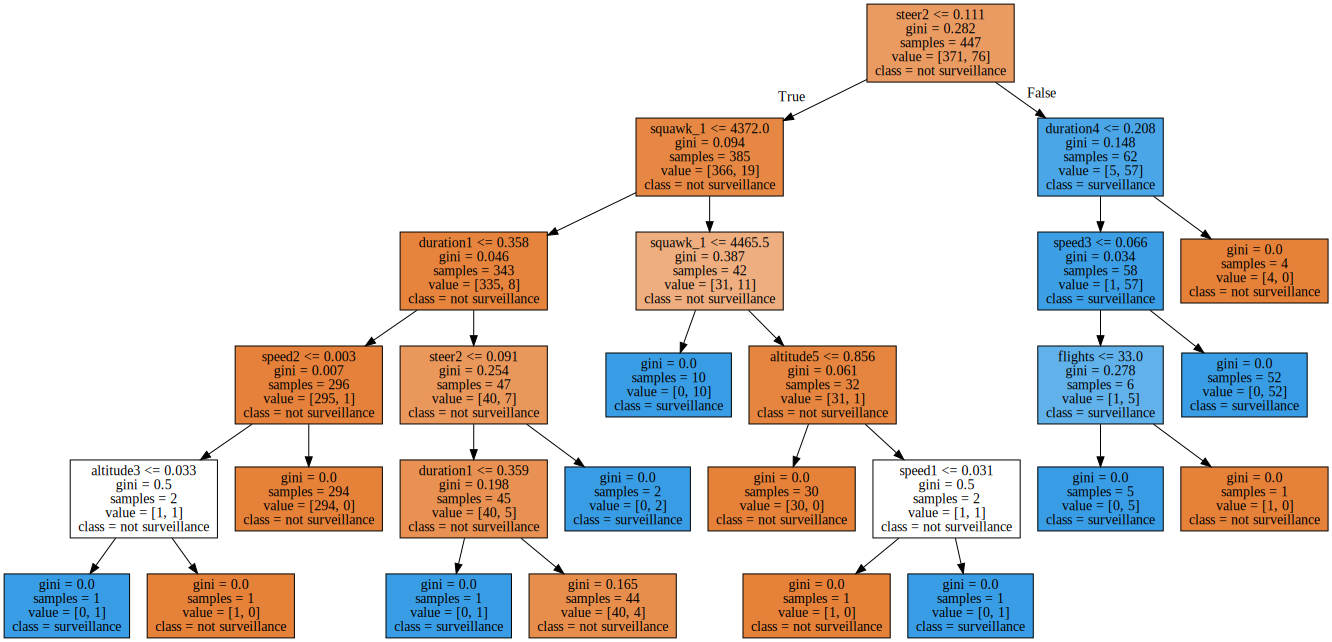

In [43]:
from sklearn import tree
import graphviz

label_names = ['not surveillance', 'surveillance']
feature_names = X.columns

dot_data = tree.export_graphviz(clf,
                    feature_names=feature_names,  
                    filled=True,
                    class_names=label_names)  
graph = graphviz.Source(dot_data)  
graph

# One more classifier: Random forest

## Build and train your classifier

We can build a random forest classifier like this:

```python
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
```

But you're in charge of fitting it to your training data!

* **Tip:** You can also set `max_depth` here, but you won't be able to visualize the result.
* **Tip:** Increase `n_estimators` to 100 to make a better classifier.

In [44]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, max_depth=5)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## What are the important features?

In [45]:
feature_names = X.columns
importances = clf.feature_importances_

pd.DataFrame({
    'feature': feature_names,
    'feature importance': importances,
}).sort_values(by='feature importance', ascending=False)

,feature,feature importance
21,steer2,0.230350
29,squawk_1,0.135064
24,steer5,0.108513
20,steer1,0.085134
23,steer4,0.042050
17,altitude3,0.030432
25,steer6,0.030281
10,speed1,0.028136
19,altitude5,0.025646
15,altitude1,0.024946


### Understanding the output

What is a random forest, and **why is the feature importance difference than for the decision tree?** Isn't a random forest just like a decision tree or something?

In [46]:
# It's a lot of decision trees that all work together, so it'll even try to use less useful features

## How well does it perform?

In [48]:
from sklearn.metrics import confusion_matrix

y_true = y_test
y_pred = clf.predict(X_test)
matrix = confusion_matrix(y_true, y_pred)

label_names = pd.Series(['not surveil', 'surveil'])
pd.DataFrame(matrix,
     columns='Predicted ' + label_names,
     index='Is ' + label_names)

,Predicted not surveil,Predicted surveil
Is not surveil,129,0
Is surveil,4,17


### How confident do you feel in the model?

In [49]:
# Very confident

# Actually finding spy planes

Now let's try ot actually find our spy planes

## Retrain our model

When we did test/train split, we trained our model with only a subset of our data, so we could test with the rest. Now that we're working in the "real world" we want to re-train it using not just `_train` and `_test` data, but instead **everything we have labels for.**

In [50]:
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## Filter for planes we want to predict

We have a dataframe of features that includes three types of planes:

* Those that are labeled as surveillance planes
* Those that are labeled as not surveillance
* Those that aren't labeled

Which do we want to predictions for? **Filter a new dataframe that's just those.**

* **Tip:** Scroll up to see where you created your `train_df`, it's the opposite!

In [51]:
real_df = df[df.label.isna()]

How many planes do you have in that list? **Confirm it's about 19,200.**

In [52]:
real_df.shape

(19202, 35)

## Predicting 

Build your `X` - remember you need to drop a few columns - and use that to make a prediction for each plane.

**Assign the prediction into the `predicted` column**.

* **Tip:** Scroll up to see where you created your features for training, it's similar
* **Tip:** pandas will yell at us about setting values on copies of a slice but it's fine

In [53]:
X = real_df.drop(columns=['label', 'adshex', 'type'])
real_df['predicted'] = clf.predict(X)

## How many planes did it predict to be surveillance planes?

It should be roughly around 70-80 planes.

In [55]:
real_df[real_df.predicted == 1].shape

(80, 36)

## But.. what about those other ones? The ones that are just below the threshold?

The cutoff for a prediction of `1` is 50%, but since we have a lot of time we're interested in investigating the top 150. To get the probability for each row, you will use `clf.predict_proba` instead of `clf.predict`. Also, to get the predicted probability for the `1` category, you'll need to add `[:,1]` to the end of the

```python
clf.predict_proba(***your features***)[:,1]
```

**Create a new column called `predicted_prob` that is the chance that the plane is a surveillance plane.**

* **Tip:** You dropped three columns when using `clf.predict`, but if you drop the same three you'll get an error now. There's now an extra column that you'll need to drop! What is it?

In [56]:
# Predict the probability it's in the class represented by '1'
real_df['predicted_prob'] = clf.predict_proba(real_df.drop(columns=['label', 'adshex', 'type', 'predicted']))[:,1]
real_df.head()

,adshex,label,duration1,duration2,duration3,duration4,duration5,boxes1,boxes2,boxes3,boxes4,boxes5,speed1,speed2,speed3,speed4,speed5,altitude1,altitude2,altitude3,altitude4,altitude5,steer1,steer2,steer3,steer4,steer5,steer6,steer7,steer8,flights,squawk_1,observations,type,type_code,predicted,predicted_prob
597,A,NaN,0.120253,0.075949,0.183544,0.335443,0.284810,0.088608,0.044304,0.069620,0.120253,0.677215,0.021824,0.020550,0.062330,0.100713,0.794582,0.042374,0.060971,0.066831,0.106403,0.723421,0.020211,0.048913,0.270550,0.344090,0.097317,0.186651,0.011379,0.009426,158,0,11776,GRND,248,0.0,0.009302
598,A00000,NaN,0.211735,0.155612,0.181122,0.198980,0.252551,0.204082,0.183673,0.168367,0.173469,0.267857,0.107348,0.143410,0.208139,0.177013,0.364090,0.177318,0.114457,0.129648,0.197694,0.380882,0.034976,0.048127,0.240732,0.356314,0.116116,0.159325,0.012828,0.013628,392,0,52465,TBM7,431,0.0,0.030403
599,A00008,NaN,0.125000,0.041667,0.208333,0.166667,0.458333,0.125000,0.083333,0.125000,0.166667,0.500000,0.187960,0.278952,0.221048,0.190257,0.121783,0.014706,0.053309,0.149816,0.279871,0.502298,0.029871,0.044118,0.202665,0.380515,0.094669,0.182904,0.014706,0.020221,24,0,2176,PA46,350,0.0,0.004275
600,A0001E,NaN,0.100000,0.200000,0.200000,0.400000,0.100000,0.100000,0.000000,0.100000,0.400000,0.400000,0.007937,0.026984,0.084127,0.179365,0.701587,0.041270,0.085714,0.039683,0.111111,0.722222,0.019048,0.049206,0.249206,0.326984,0.112698,0.206349,0.012698,0.011111,10,1135,630,C56X,126,0.0,0.005358
601,A0002B,NaN,0.166667,0.166667,0.000000,0.666667,0.000000,0.333333,0.000000,0.000000,0.666667,0.000000,0.767405,0.191456,0.023734,0.017405,0.000000,0.150316,0.113924,0.178797,0.534810,0.022152,0.001582,0.009494,0.281646,0.416139,0.112342,0.169304,0.001582,0.001582,6,2356,632,C82S,133,0.0,0.035157


### Get the top 200 predictions

Take a look at what the probabilities look like, showing the top 200 planes that are **most likely to be surveillance planes.**

Then save them to a file for later research.

In [57]:
top_predictions = real_df.sort_values(by='predicted_prob', ascending=False).head(200)
top_predictions

,adshex,label,duration1,duration2,duration3,duration4,duration5,boxes1,boxes2,boxes3,boxes4,boxes5,speed1,speed2,speed3,speed4,speed5,altitude1,altitude2,altitude3,altitude4,altitude5,steer1,steer2,steer3,steer4,steer5,steer6,steer7,steer8,flights,squawk_1,observations,type,type_code,predicted,predicted_prob
8466,A4FB3C,NaN,0.416667,0.125000,0.083333,0.041667,0.333333,0.458333,0.458333,0.083333,0.000000,0.000000,0.562937,0.226224,0.138811,0.056294,0.015734,0.000000,0.009091,0.039860,0.866434,0.084615,0.144406,0.226923,0.222378,0.268182,0.013986,0.062587,0.004196,0.017483,24,5310,2860,P210,322,1.0,0.951233
3616,A1B621,NaN,0.615385,0.076923,0.153846,0.000000,0.153846,0.538462,0.307692,0.076923,0.076923,0.000000,0.524156,0.331568,0.103243,0.039709,0.001324,0.053607,0.080079,0.756453,0.105228,0.004633,0.455328,0.173395,0.138981,0.052945,0.021840,0.049636,0.001985,0.008604,13,5240,1511,C210,98,1.0,0.938052
2828,A144AF,NaN,0.328358,0.134328,0.074627,0.029851,0.432836,0.492537,0.328358,0.164179,0.000000,0.014925,0.134059,0.274446,0.197484,0.148554,0.245457,0.001251,0.005371,0.008167,0.053271,0.931940,0.152969,0.248841,0.266132,0.175116,0.010448,0.064013,0.014495,0.018247,67,5103,13591,unknown,454,1.0,0.920856
680,A005D8,NaN,0.241379,0.137931,0.137931,0.103448,0.379310,0.241379,0.068966,0.310345,0.206897,0.172414,0.245460,0.389500,0.232983,0.048178,0.083879,0.000988,0.005559,0.018653,0.096603,0.878196,0.105991,0.220630,0.335145,0.193823,0.015442,0.070043,0.007288,0.016553,29,5011,8095,unknown,454,1.0,0.916384
8428,A4F784,NaN,0.387097,0.161290,0.000000,0.000000,0.451613,0.548387,0.161290,0.225806,0.000000,0.064516,0.125439,0.236160,0.203713,0.182806,0.251882,0.000335,0.004516,0.010537,0.025088,0.959525,0.123599,0.209065,0.267269,0.236160,0.012209,0.075263,0.016725,0.016056,31,5101,5979,unknown,454,1.0,0.889489
10209,A63E52,NaN,0.333333,0.196078,0.137255,0.078431,0.254902,0.549020,0.313725,0.137255,0.000000,0.000000,0.817386,0.122310,0.051307,0.005714,0.003283,0.077204,0.297143,0.622492,0.003161,0.000000,0.207295,0.219210,0.251185,0.125471,0.028571,0.075137,0.009848,0.019574,51,5306,8225,T206,417,1.0,0.876497
2720,A13098,NaN,0.166667,0.166667,0.166667,0.083333,0.416667,0.250000,0.583333,0.166667,0.000000,0.000000,0.866572,0.071664,0.035361,0.020745,0.005658,0.053748,0.123055,0.665724,0.157473,0.000000,0.151344,0.176803,0.181047,0.300802,0.019331,0.085809,0.010372,0.028289,12,4415,2121,unknown,454,1.0,0.873517
14433,A996CB,NaN,0.444444,0.277778,0.166667,0.000000,0.111111,0.722222,0.277778,0.000000,0.000000,0.000000,0.375196,0.351648,0.191523,0.043956,0.037677,0.001570,0.037677,0.821036,0.133438,0.006279,0.257457,0.211931,0.196232,0.043956,0.009419,0.087912,0.015699,0.059655,18,0,637,C208,97,1.0,0.872198
12275,A7D925,NaN,0.121212,0.141414,0.070707,0.070707,0.595960,0.212121,0.515152,0.242424,0.030303,0.000000,0.271168,0.494554,0.212671,0.016859,0.004747,0.018678,0.065840,0.345793,0.568557,0.001131,0.166840,0.315047,0.301537,0.096653,0.015661,0.047095,0.004015,0.009250,99,230,45079,T206,417,1.0,0.871983
9204,A565E6,NaN,0.333333,0.200000,0.066667,0.000000,0.400000,0.600000,0.266667,0.133333,0.000000,0.000000,0.058968,0.120803,0.190418,0.151515,0.478296,0.000819,0.001229,0.017199,0.014742,0.966011,0.106880,0.240377,0.303440,0.207617,0.008190,0.064701,0.014333,0.017199,15,5106,2442,unknown,454,1.0,0.857310


In [58]:
top_predictions.to_csv("planes-to-research.csv")

# Questions

### Question 1

What kind of machine learning are we doing here, and why are we doing it?

In [217]:
# Classification (or supervised learning) because we have labels

### Question 2

What are a few different ways you can deal with categorical data? Think about how we dealt with race in the reveal regression compared to how we dealt with type in this dataset.

In [ ]:
# You can one-hot encode them if you have few
# You can just make them numbers if you have a lot

### Question 3

Every time we ran a machine learning algorithm on our dataset, we looked at feature importance.

* When might it be important to explain what our model found important?
* When might it not be important?

In [218]:
# If we're trying to understand what's going wrong or why it is/isn't working well
# It's more important if we're presenting this to the public

### Question 4

Using words and not column names, describe what the machine learning algorithm found to be important when identifying surveillance planes.

In [220]:
# Slow speed, constant turning vs going straight

### Question 5

Why did we use test/train split when it would have been more effective to give our model all of the data from the start?

In [221]:
# Shouldn't test on things that it's already seen

### Question 6

Why did we use a random forest instead of a decision tree or logistic regression? Was there something about the data?

In [222]:
# Because it did a better job!!!

### Question 7

Why did we use probability instead of just looking for planes with a predicted value of 1? It seems like we should have just trusted the algorithm, right?

In [223]:
# The 0/1 is an arbitrary cutoff of 50%, we're fine going lower because it gives us more to research

### Question 8

What if our random forest or input dataset were flawed? What would be the repercussions?

In [224]:
# We'd be investigating a bunch of planes that didn't need to be investigated

### Question 9

The government could claim that we're threatening national security by publishing this paper as well as publishing this code - now anyone could look for planes that are surveilling them. What do you think?

In [ ]:
# Up to you!

### Question 10

We're using data from the past, but you can get real-time flight data from many services. Can you think of any uses for this algorithm using real-time instead of historical data?

In [ ]:
# Finding out when something crazy is going on police-wise, maybe

### Question 11

This isn't a question, but if you look at `candidates.csv` and `candidates-annotates.csv` you can see how Buzzfeed did their research after finding a list of suspicious planes.

In [ ]:
# k